In [278]:
import sys
sys.path.append('/Users/laurenthericourt/projets/trading/trading')
import warnings
warnings.filterwarnings('ignore')

import psycopg2
import numpy as np
import pandas as pd
from pandas.io.sql import read_sql
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
from tqdm import tqdm
import yfinance as yf


from config.load import load_conf
from db.utils import get_uri_db
from utils.utils import AnnualGranularity, get_candles
from 
from indicator.oscillator import Atr, Macd, Rsi, Stochastic, Obv
from indicator.trend import BollingerBands, Adx, Slope, MovingAverage, HullMovingAverage

In [2]:
load_conf('../config/configuration.yaml')
dsn = get_uri_db()
schema = 'trading'

# Get Data

In [3]:
start_date = '2015-01-01'
end_date = '2021-01-01'

all_candles = get_candles(dsn, schema, start_date, end_date)

In [4]:
candles = all_candles[(all_candles['table'] == 'candle1h') & (all_candles['symbol'] == 'EUR/USD')]

In [283]:
tsla_df = yf.download('TSLA', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [285]:
candles.head()

,table,date,symbol,open,close,low,high,tickqty,ma_50_%,ma_200_%,ma_50_200_%,macd,obv_1,obv_3,obv_5,rsi,rsi_3,hull_rsi,bb_up_%,bb_down_%,adx_14,adx_20,adx_5,atr_%,atr_ewm_%,stoch,atr_up,n_atr_up,atr_down,n_atr_down
5456054,candle1h,2015-01-02 03:00:00,EUR/USD,1.21008,1.20586,1.20576,1.21008,1068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5456055,candle1h,2015-01-02 04:00:00,EUR/USD,1.20586,1.20540,1.20501,1.20609,4281,NaN,NaN,NaN,NaN,-299.580980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5456056,candle1h,2015-01-02 05:00:00,EUR/USD,1.20540,1.20531,1.20470,1.20566,4253,NaN,NaN,NaN,NaN,99.345947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5456057,candle1h,2015-01-02 06:00:00,EUR/USD,1.20531,1.20556,1.20496,1.20587,4324,NaN,NaN,NaN,NaN,-50.667917,-451.542255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5456058,candle1h,2015-01-02 07:00:00,EUR/USD,1.20556,1.20571,1.20356,1.20591,11343,NaN,NaN,NaN,NaN,-269.429929,-266.619949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [286]:
tsla_df.reset_index(inplace=True)

In [287]:
tsla_df.head()

,Date,Open,High,Low,Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,34334500


In [288]:
tsla_df.columns = ['date', 'open', 'high', 'low', 'close', 'tickqty']

In [289]:
candles = tsla_df

# Compute indicator
## Moving average

In [290]:
ma = MovingAverage(candles)
ma_200 = ma.compute(200)
ma_50 = ma.compute(50)

In [291]:
candles['ma_50_%'] = 1000 * (ma_50 - candles['close']) / candles['close']
candles['ma_200_%'] =  1000 * (ma_200 - candles['close']) / candles['close']
candles['ma_50_200_%'] =  1000 * (ma_50 - ma_200) / candles['close']

## MACD

In [292]:
macd = Macd(candles)
res = macd.compute()

In [293]:
hist = res[0] - res[1]

In [294]:
candles['macd'] = 10000 * hist

## OBV

In [295]:
obv = Obv(candles)
res = obv.compute()

In [296]:
candles['obv_1'] = 100 * pd.DataFrame(res).pct_change(periods=1).values
candles['obv_3'] = 100 * pd.DataFrame(res).pct_change(periods=3).values
candles['obv_5'] = 100 * pd.DataFrame(res).pct_change(periods=5).values

In [297]:
def remove_unusual_values(candles, col):
    q_min = candles[col].quantile(0.001)
    q_max = candles[col].quantile(0.999)
    candles[col] = np.where(candles[col] > q_max, q_max, candles[col])
    candles[col] = np.where(candles[col] < q_min, q_min, candles[col])

In [298]:
for col in ['obv_1', 'obv_3', 'obv_5']:
    remove_unusual_values(candles, col)

## RSI

In [299]:
rsi = Rsi(candles)
candles['rsi'] = rsi.compute()

## Tri RSI

In [300]:
span = 5
rsi_1 = Rsi(candles)
candles['rsi_1'] = rsi_1.compute(span)

rsi_2 = Rsi(candles, 'rsi_1')
candles['rsi_2'] = rsi_2.compute(span)

rsi_3 = Rsi(candles, 'rsi_2')
candles['rsi_3'] = rsi_3.compute(span)

In [301]:
del candles['rsi_1']
del candles['rsi_2']

## Hull RSI

In [302]:
span = 6
delta = candles['close'] - candles['close'].shift(1)
candles['delta_pos'] = np.where(delta >= 0, delta, 0)
candles['delta_neg'] = np.where(delta < 0, abs(delta), 0)
candles['delta_hull_pos'] = HullMovingAverage(candles, col='delta_pos').compute(span)
candles['delta_hull_neg'] = HullMovingAverage(candles, col='delta_neg').compute(span)
candles['rs'] = candles['delta_hull_pos'] / candles['delta_hull_neg']
candles['rs'].replace([np.inf, -np.inf], 1e10, inplace=True)
candles['hull_rsi'] = 100 - 100 / (1 + candles['rs'])
candles['hull_rsi'] = np.where(candles['hull_rsi'] >= 100, 100, candles['hull_rsi'])
candles['hull_rsi'] = np.where(candles['hull_rsi'] < 0, 0, candles['hull_rsi'])

In [303]:
del candles['delta_pos']
del candles['delta_neg']
del candles['delta_hull_pos']
del candles['delta_hull_neg']
del candles['rs']
del candles['wma_span1']
del candles['wma_span2']
del candles['diff_wma']

## BollingerBands

In [304]:
bb = BollingerBands(candles)
res = bb.compute()
candles['bb_up_%'] = 1000 * (res[1] - candles['close']) / candles['close']
candles['bb_down_%'] = 1000 * (res[2] - candles['close']) / candles['close']

## Adx

In [305]:
adx = Adx(candles)
res = adx.compute(span=14)
candles['adx_14'] = res[2]
res = adx.compute(span=20)
candles['adx_20'] = res[2]
res = adx.compute(span=5)
candles['adx_5'] = res[2]

## Atr

In [306]:
atr = Atr(candles)
res = atr.compute()
candles['atr_%'] = 1e4 * res[0] / candles['close']

res = atr.compute(avg_type='ewm')
candles['atr_ewm_%'] = 1e4 * res[0] / candles['close']

## Stochastic

In [307]:
stoch = Stochastic(candles)
_, _, candles['stoch'] = stoch.compute()
candles.tail()

,date,open,high,low,close,tickqty,ma_50_%,ma_200_%,ma_50_200_%,macd,obv_1,obv_3,obv_5,rsi,rsi_3,hull_rsi,bb_up_%,bb_down_%,adx_14,adx_20,adx_5,atr_%,atr_ewm_%,stoch
2721,2021-04-21,704.770020,744.840027,698.000000,744.119995,31215500,-59.459224,-257.057864,197.598640,74918.004995,0.607814,0.528005,1.630825,58.128750,55.694750,75.421899,43.456899,-197.878224,19.494095,17.618353,33.274252,442.948866,482.301057,6.226207
2722,2021-04-22,741.500000,753.770020,718.039978,719.690002,35590300,-31.138692,-228.769767,197.631075,54623.985921,-0.688811,0.612424,0.380919,53.202116,40.203829,57.868723,80.965929,-160.313998,19.088897,17.095980,29.659716,460.694377,498.378375,-11.244035
2723,2021-04-23,719.799988,737.359985,715.460022,729.400024,28370000,-46.104505,-235.909254,189.804750,44539.076387,0.552879,0.467224,0.387527,54.840407,47.746166,50.576130,70.144956,-162.858217,18.622221,16.560674,25.829947,430.559333,466.210789,-2.229285
2724,2021-04-26,741.000000,749.299988,732.609985,738.200012,30584700,-59.466016,-241.906638,182.440622,40699.430433,0.592762,0.452192,1.768378,56.332412,54.093487,64.240594,57.108301,-156.371415,18.516919,16.212604,26.178231,429.993755,435.175948,8.059616
2725,2021-04-27,717.960022,724.000000,705.099976,710.799988,22156350,-26.173593,-209.856657,183.683064,17780.710960,-0.426882,0.717132,0.631337,50.714137,37.708222,25.117440,87.396816,-99.390319,17.454418,15.461256,24.471746,455.934993,453.780753,-14.165169


for col ina

# Compute y

In [308]:
classes = ['sell', 'buy', 'nothing']

In [309]:
atr = Atr(candles)
res = atr.compute(avg_type='ewm')

In [310]:
n = 2
candles['atr_up'] = candles['high'] + res[0]
candles['n_atr_up'] = candles['high'] + n * res[0]
candles['atr_down'] = candles['low'] - res[0]
candles['n_atr_down'] = candles['low'] - n * res[0]

In [311]:
y

['sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'buy',
 'buy',
 'buy',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'sell',
 'buy',
 'sell',
 'sell',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'sell',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 'buy',
 

In [312]:
candles_no_na = candles.dropna(axis=0).reset_index(drop=True)
y = list()
for c in tqdm(candles_no_na.itertuples()):
    class_ = 'nothing'
    for c_next in candles_no_na.loc[int(c.Index) + 1: ].itertuples():
        if c_next.high > c.n_atr_up and c_next.low > c.atr_down:
            class_ = 'buy'
            break
        elif c_next.high > c.n_atr_up and c_next.low < c.atr_down:
            break
        elif c_next.high < c.atr_up and c_next.low < c.n_atr_down:
            class_ = 'sell'
            break
        elif c_next.high > c.atr_up and c_next.low < c.n_atr_down:
            break
    y.append(class_)
            

2527it [00:08, 305.44it/s]


In [313]:
candles_no_na['y'] = [classes.index(x) for x in y]

In [314]:
candles_no_na['y'].value_counts()

1    1512
0     989
2      26
Name: y, dtype: int64

# Modeling
## Split train / test

In [315]:
candles_for_model = candles_no_na[candles_no_na['y'].isin([0, 1])]

In [316]:
cols_for_model = [x for x in candles_for_model.columns if x not in ['y', 'date', 'table', 'symbol', 'open', 'close', 'low', 'high', 'tickqty']]

In [317]:
train_size = int(candles_for_model.shape[0] * 0.8)
X_train = candles_for_model.loc[0 : train_size, cols_for_model]
y_train = candles_for_model.loc[0 : train_size, 'y']

X_test = candles_for_model.loc[train_size + 1: , cols_for_model]
y_test= candles_for_model.loc[train_size + 1:, 'y']

## metrics

In [318]:
def compute_metrics(model, X, y):
    y_pred = model.predict(X)
    report = pd.DataFrame(precision_recall_fscore_support(y, y_pred), columns=['sell', 'buy'])
    report['index'] = ['precision', 'recall', 'f1', 'support']
    report.set_index('index', inplace=True)
    print(report)
    print("######################")
    print("accuracy {}".format(accuracy_score(y, y_pred)))

## logistic regression

In [319]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [320]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [321]:
compute_metrics(lr, X_train, y_train)

                 sell          buy
index                             
precision    0.610675     0.663235
recall       0.459268     0.784348
f1           0.524259     0.718725
support    847.000000  1150.000000
######################
accuracy 0.6464697045568353


In [322]:
compute_metrics(lr, X_test, y_test)

                 sell         buy
index                            
precision    0.247024    0.648810
recall       0.584507    0.301105
f1           0.347280    0.411321
support    142.000000  362.000000
######################
accuracy 0.38095238095238093


In [237]:
precision_recall_fscore_support(y_train, lr.predict(X_train))

(array([0.55373441, 0.55153707]),
 array([0.59140523, 0.51321601]),
 array([0.57195021, 0.53168694]),
 array([14567, 14263]))

In [240]:
accuracy_score(y_train, lr.predict(X_train))

0.5527228581338883

In [238]:
precision_recall_fscore_support(y_test, lr.predict(X_test))

(array([0.51639344, 0.56506329]),
 array([0.55492228, 0.52666352]),
 array([0.53496503, 0.54518808]),
 array([3860, 4238]))

In [239]:
accuracy_score(y_test, lr.predict(X_test))

0.5401333662632749

In [203]:
proba_0 = lr.predict_proba(X_test)[:, 0]

In [204]:
proba_0

array([0.2717588 , 0.40431684, 0.36322688, ..., 0.51122712, 0.4700495 ,
       0.5708886 ])

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

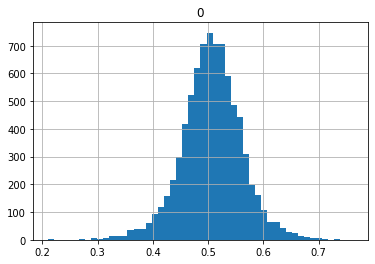

In [209]:
pd.DataFrame(proba_0).hist(bins=50)

In [219]:
y_test.values[np.where(proba_0 < 0.3)[0]].shape

(13,)

In [ ]:
173